# Data Engineering Pipeline Explained

This notebook demonstrates and explains the data engineering process for the Asian Market Quant project. We'll work with the pickle files you've already generated from Step 1 (Asset Class Mapping) to implement the full data engineering pipeline.

## What We'll Cover:

1. **Loading the Asset Class Data**: Loading the .pkl files from Step 1
2. **Data Quality Assessment**: Checking for missing values, outliers, etc.
3. **Currency Normalization**: Converting all assets to USD
4. **Handling Corporate Actions**: Adjusting for dividends and splits
5. **Futures Contract Roll Management**: Creating continuous futures series
6. **Returns Calculation**: Computing daily and monthly returns
7. **Data Storage**: Saving the processed data in standardized formats

Let's get started!


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path
import datetime as dt
import warnings

# Add project root to path for imports
sys.path.append('..')

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Import our data engineering module
from src.data_engineering import (
    load_raw_data,
    clean_and_standardize,
    normalize_to_usd,
    adjust_for_corporate_actions,
    handle_futures_rolls,
    calculate_returns,
    create_data_dictionary
)

# Import asset class mapping
from src.asset_class_mapping import ASSET_MAPPING, create_ticker_to_asset_class_map

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (12, 6)

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)

print("Libraries and modules imported successfully!")

Libraries and modules imported successfully!


## 1. Loading the Asset Class Data

First, we'll load the pickle files that were generated in Step 1. These files contain data already categorized into asset classes:

- `all_assets.pkl`: Complete dataset with all assets
- `emerging_asia_equity.pkl`: Asian equity indices & ETFs
- `commodities.pkl`: Commodities like gold, oil, softs
- `developed_equity.pkl`: Developed market equity indices
- `fx_crosses.pkl`: FX rates (currency pairs)
- `sovereign_yields.pkl`: Government bond yields

Let's load these files and explore their structure:


In [2]:
# Define paths to our pickle files
data_dir = Path('../data/processed')

# Create a dictionary to store our data
asset_class_data = {}

# Load each asset class pickle file
pickle_files = {
    'all_assets': 'all_assets.pkl',
    'emerging_asia_equity': 'emerging_asia_equity.pkl',
    'commodities': 'commodities.pkl',
    'developed_equity': 'developed_equity.pkl',
    'fx_crosses': 'fx_crosses.pkl',
    'sovereign_yields': 'sovereign_yields.pkl'
}

for key, filename in pickle_files.items():
    file_path = data_dir / filename
    if file_path.exists():
        asset_class_data[key] = pd.read_pickle(file_path)
        print(f"Loaded {key} from {file_path}")
    else:
        print(f"Warning: {file_path} not found")

# Display basic information for each asset class dataframe
for asset_class, df in asset_class_data.items():
    print(f"\n{asset_class.upper()} DATASET:")
    print("-" * 50)
    print(f"Shape: {df.shape}")
    print(f"Date range: {df.index[0]} to {df.index[-1]}")
    print(f"Number of tickers: {len(df.columns)}")
    print(f"Tickers: {', '.join(df.columns[:5])}{' ...' if len(df.columns) > 5 else ''}")
    
# Show a preview of the all_assets dataframe
if 'all_assets' in asset_class_data:
    print("\nPreview of all_assets dataframe:")
    display(asset_class_data['all_assets'].head())

Loaded all_assets from ../data/processed/all_assets.pkl
Loaded emerging_asia_equity from ../data/processed/emerging_asia_equity.pkl
Loaded commodities from ../data/processed/commodities.pkl
Loaded developed_equity from ../data/processed/developed_equity.pkl
Loaded fx_crosses from ../data/processed/fx_crosses.pkl
Loaded sovereign_yields from ../data/processed/sovereign_yields.pkl

ALL_ASSETS DATASET:
--------------------------------------------------
Shape: (9713, 26)
Date range: 1988-01-04 00:00:00 to 2025-03-26 00:00:00
Number of tickers: 26
Tickers: MXAP Index, MXAPJ Index, MXAS Index, MXASJ Index, PCOMP Index ...

EMERGING_ASIA_EQUITY DATASET:
--------------------------------------------------
Shape: (9713, 12)
Date range: 1988-01-04 00:00:00 to 2025-03-26 00:00:00
Number of tickers: 12
Tickers: MXAP Index, MXAPJ Index, MXAS Index, MXASJ Index, PCOMP Index ...

COMMODITIES DATASET:
--------------------------------------------------
Shape: (9713, 3)
Date range: 1988-01-04 00:00:00 to

,MXAP Index,MXAPJ Index,MXAS Index,MXASJ Index,PCOMP Index,JCI Index,FBMKLCI Index,SET Index,STI Index,NU710465 Index,EPHE US Index,Unnamed: 12,GOLDS Index,CO1 Comdty,S 1 Comdty,FMETF PM Equity,SPX Index,NKY Index,USDPHP Index,USDMYR Index,USDIDR Index,USDSGD Index,USDJPY Curncy,USGG5YR Index,GTPHP5yr Corp,GTUSDPH5Y Corp
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
1988-01-04,97.02,98.98,96.97,99.73,832.32,82.58,260.51,287.71,NaN,NaN,NaN,NaN,480.5,NaN,616.25,NaN,255.94,21217.04,NaN,2.4950,NaN,1.9970,122.70,8.330,NaN,NaN
1988-01-05,95.30,101.08,95.20,104.40,820.96,82.60,274.84,301.91,NaN,NaN,NaN,NaN,475.5,NaN,614.25,NaN,258.63,21575.28,NaN,2.5165,NaN,2.0015,126.90,8.269,NaN,NaN
1988-01-06,99.19,102.61,99.22,107.12,833.60,82.71,283.95,315.14,NaN,NaN,NaN,NaN,481.4,NaN,626.00,NaN,258.89,22790.50,NaN,2.5390,NaN,2.0180,129.65,8.399,NaN,NaN
1988-01-07,99.96,102.32,100.04,106.86,850.86,82.62,285.32,320.26,NaN,NaN,NaN,NaN,483.5,NaN,619.75,NaN,261.07,22792.13,NaN,2.5350,NaN,2.0350,128.58,8.330,NaN,NaN
1988-01-08,98.94,101.81,99.00,106.62,878.02,82.62,284.11,327.37,NaN,NaN,NaN,NaN,483.9,NaN,623.50,NaN,243.40,22872.56,NaN,2.5325,NaN,2.0350,129.15,8.430,NaN,NaN


## 2. Data Quality Assessment

Next, let's assess the quality of our data. This involves checking for:

1. Missing values (NaNs) - data gaps that need to be handled
2. Outliers - extreme values that may be errors or need special handling
3. Data types - ensuring all columns are numeric
4. Time series consistency - checking for uniform frequency and timespan

Let's analyze the raw data before proceeding with cleaning steps:


Total missing values: 38,981
Percentage of missing data: 15.44%

Columns with most missing values:


,Missing Values,Percentage
Unnamed: 12,9713,100.000000
FMETF PM Equity,6760,69.597447
EPHE US Index,5932,61.072789
GTUSDPH5Y Corp,5809,59.806445
STI Index,3041,31.308556
NU710465 Index,2845,29.290641
GTPHP5yr Corp,2756,28.374344
USDIDR Index,1001,10.305776
USDPHP Index,1001,10.305776
CO1 Comdty,123,1.266344



Data types:


float64    26
Name: count, dtype: int64


Date index information:
Frequency: B
Start date: 1988-01-04 00:00:00
End date: 2025-03-26 00:00:00
Number of dates: 9713
Expected dates for daily business day frequency: 9713

Summary statistics:


,MXAP Index,MXAPJ Index,MXAS Index,MXASJ Index,PCOMP Index,JCI Index,FBMKLCI Index,SET Index,STI Index,NU710465 Index,EPHE US Index,Unnamed: 12,GOLDS Index,CO1 Comdty,S 1 Comdty,FMETF PM Equity,SPX Index,NKY Index,USDPHP Index,USDMYR Index,USDIDR Index,USDSGD Index,USDJPY Curncy,USGG5YR Index,GTPHP5yr Corp,GTUSDPH5Y Corp
count,9713.000000,9713.000000,9713.000000,9713.000000,9713.000000,9713.000000,9713.000000,9713.000000,6672.000000,6868.000000,3781.000000,0.0,9713.000000,9590.000000,9713.000000,2953.000000,9713.000000,9713.000000,8712.000000,9713.000000,8712.000000,9713.000000,9713.000000,9713.000000,6957.000000,3904.000000
mean,124.305956,343.264467,115.765652,417.827374,3780.164747,2664.918411,1137.917829,989.690312,2740.213449,3157.781158,31.348515,NaN,897.272044,51.718735,877.377188,106.053667,1646.720811,18869.622327,44.647335,3.493623,9651.686524,1.521593,114.465674,4.001067,8.130967,2.457580
std,33.060478,157.245231,29.460620,195.743535,2484.042031,2473.948884,455.830525,459.446027,642.776374,1914.668296,5.178598,NaN,624.476438,32.821964,328.358553,9.440032,1299.661681,7582.553388,9.848671,0.649902,4232.376099,0.204978,17.406965,2.332480,4.503733,1.193656
min,57.440000,92.190000,51.660000,97.410000,516.210000,82.580000,254.780000,207.310000,1170.850000,397.327000,19.200000,NaN,252.550000,9.640000,410.000000,71.200000,242.630000,7054.980000,23.100000,2.436000,1977.000000,1.200800,75.820000,0.190200,2.165000,0.732000
25%,99.710000,191.116400,94.960000,235.550000,1545.900000,469.205000,725.940000,629.200000,2226.950000,1122.385075,26.580000,NaN,367.100000,19.772500,586.000000,100.000000,789.260000,13165.450000,40.947500,2.770000,8497.750000,1.356600,104.950000,1.842000,4.125000,1.576000
50%,122.590000,307.660000,116.190000,396.090000,2881.400000,1327.755000,1109.530000,893.420000,2986.200000,3596.280500,31.600000,NaN,622.000000,47.370000,829.000000,105.600000,1257.540000,17690.670000,46.912500,3.663500,9420.000000,1.442000,112.450000,3.916700,6.289000,2.197500
75%,145.230000,479.628900,132.790000,571.430000,6508.340000,5012.638000,1577.790000,1420.130000,3224.380000,4922.600250,35.420000,NaN,1322.940000,75.887500,1054.000000,112.500000,2081.880000,22598.390000,51.900000,4.004300,13389.000000,1.692300,124.280000,5.789000,11.797000,2.951250
max,220.640000,743.725500,206.310000,957.550000,9058.620000,7905.390000,1895.180000,1838.960000,3967.450000,6342.077300,43.470000,NaN,3047.790000,146.080000,1771.000000,132.718000,6144.150000,42224.020000,58.999000,4.798700,16650.000000,2.054500,161.690000,9.729000,20.347000,5.742000


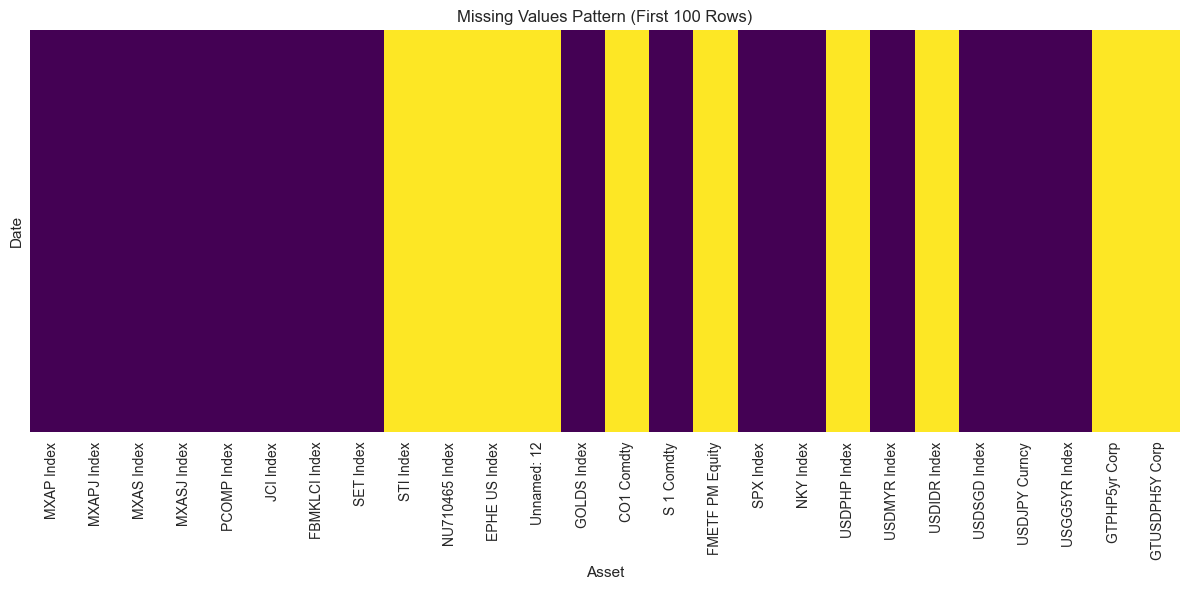

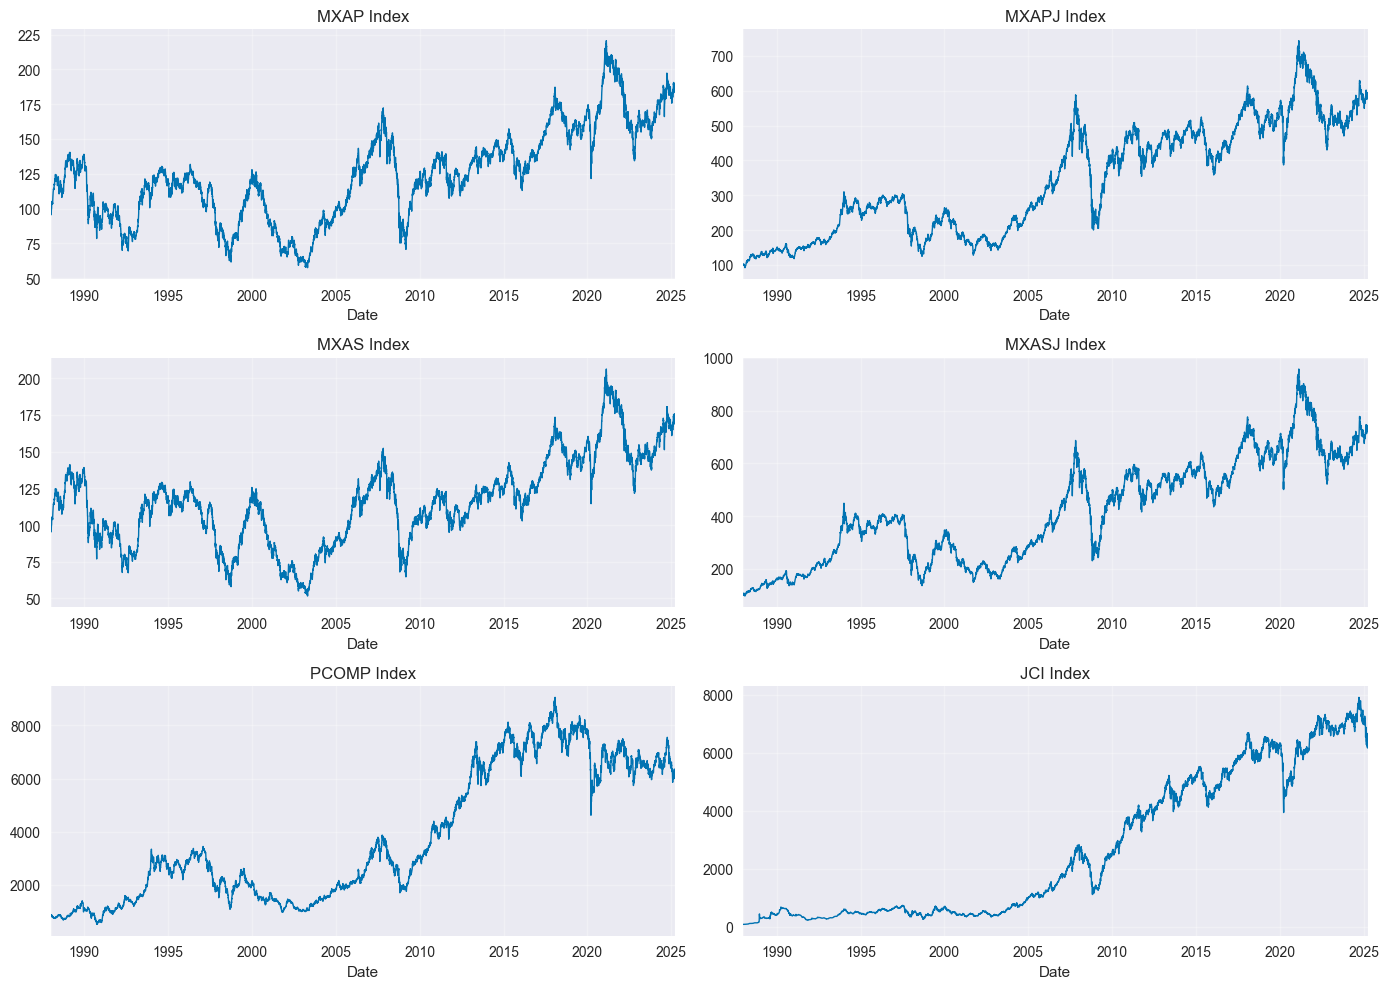

In [3]:
# Let's work with the all_assets dataset for our analysis
df = asset_class_data.get('all_assets', pd.DataFrame())

if df.empty:
    print("Error: all_assets dataframe not loaded or empty.")
else:
    # 1. Check for missing values
    missing_values = df.isna().sum()
    missing_pct = (missing_values / len(df)) * 100
    
    print(f"Total missing values: {df.isna().sum().sum():,}")
    print(f"Percentage of missing data: {(df.isna().sum().sum() / df.size) * 100:.2f}%")
    
    # Display columns with most missing values
    missing_summary = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage': missing_pct
    }).sort_values('Missing Values', ascending=False)
    
    print("\nColumns with most missing values:")
    display(missing_summary.head(10))
    
    # 2. Check data types
    print("\nData types:")
    display(df.dtypes.value_counts())
    
    # 3. Check for frequency and time series consistency
    print("\nDate index information:")
    print(f"Frequency: {pd.infer_freq(df.index)}")
    print(f"Start date: {df.index[0]}")
    print(f"End date: {df.index[-1]}")
    print(f"Number of dates: {len(df.index)}")
    print(f"Expected dates for daily business day frequency: {len(pd.date_range(df.index[0], df.index[-1], freq='B'))}")
    
    # 4. Check for potential outliers using summary statistics
    numeric_df = df.select_dtypes(include=['number'])
    
    print("\nSummary statistics:")
    display(numeric_df.describe())
    
    # 5. Visualize missing values pattern
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.iloc[:100].isna(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title('Missing Values Pattern (First 100 Rows)')
    plt.xlabel('Asset')
    plt.ylabel('Date')
    plt.tight_layout()
    plt.show()
    
    # 6. Visualize data distribution for a sample of assets
    plt.figure(figsize=(14, 10))
    for i, col in enumerate(df.columns[:6]):
        plt.subplot(3, 2, i+1)
        df[col].plot(linewidth=1)
        plt.title(col)
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 3. Data Cleaning and Standardization

Now that we understand the quality of our data, let's apply some cleaning and standardization steps:

1. Ensure the date index is properly formatted
2. Resample to business day frequency (if needed)
3. Forward-fill missing values for holidays
4. Handle any remaining missing values

These steps will ensure our time series data is consistent and ready for further processing:


Cleaning and standardizing data...
Data standardized to business day frequency
Data completeness: 84.56%
Missing values: 38981
Raw Data:
Shape: (9713, 26)
Missing values: 38,981
Data completeness: 84.56%

Cleaned Data:
Shape: (9713, 26)
Missing values: 38,981
Data completeness: 84.56%

Columns still containing missing values after cleaning:


Unnamed: 12        100.000000
FMETF PM Equity     69.597447
EPHE US Index       61.072789
GTUSDPH5Y Corp      59.806445
STI Index           31.308556
NU710465 Index      29.290641
GTPHP5yr Corp       28.374344
USDPHP Index        10.305776
USDIDR Index        10.305776
CO1 Comdty           1.266344
dtype: float64

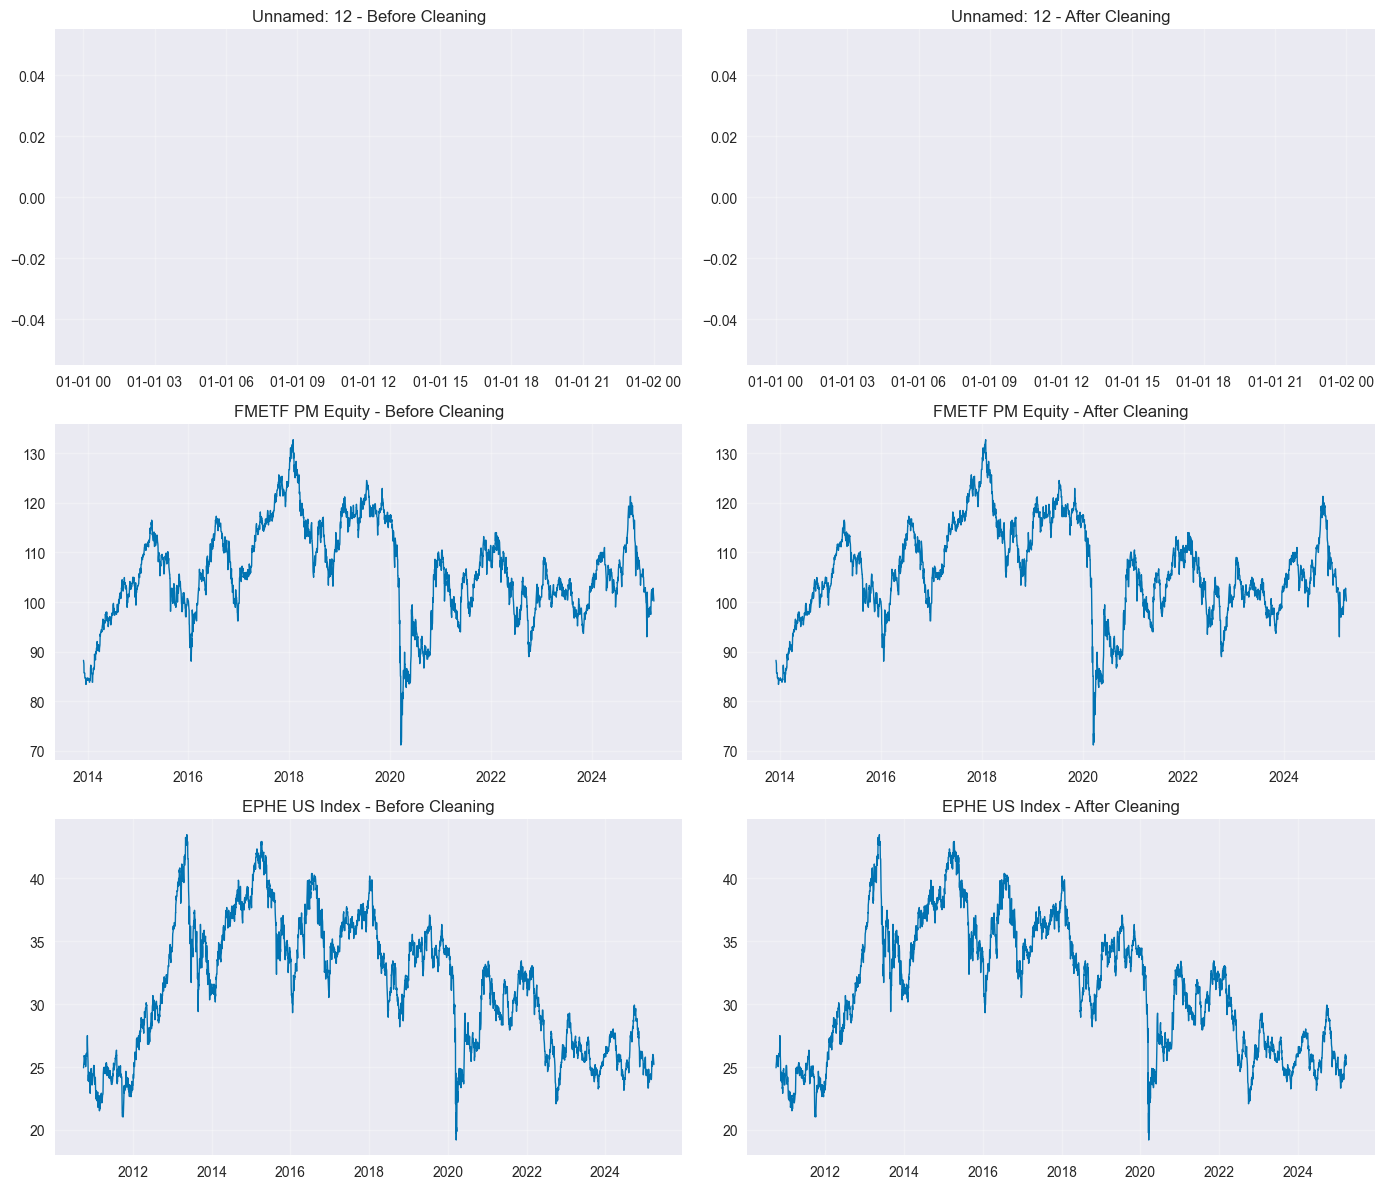

In [4]:
# Let's clean and standardize our data using the function from our module
df_cleaned = clean_and_standardize(df)

# Compare the raw and cleaned data
if df_cleaned is not None:
    print("Raw Data:")
    print(f"Shape: {df.shape}")
    print(f"Missing values: {df.isna().sum().sum():,}")
    print(f"Data completeness: {(1 - df.isna().sum().sum() / df.size) * 100:.2f}%")
    
    print("\nCleaned Data:")
    print(f"Shape: {df_cleaned.shape}")
    print(f"Missing values: {df_cleaned.isna().sum().sum():,}")
    print(f"Data completeness: {(1 - df_cleaned.isna().sum().sum() / df_cleaned.size) * 100:.2f}%")
    
    # Check if we have any remaining columns with significant missing data
    missing_after = df_cleaned.isna().sum()
    missing_pct_after = (missing_after / len(df_cleaned)) * 100
    
    columns_with_missing = missing_pct_after[missing_pct_after > 0].sort_values(ascending=False)
    
    if len(columns_with_missing) > 0:
        print("\nColumns still containing missing values after cleaning:")
        display(columns_with_missing.head(10))
    else:
        print("\nAll missing values have been handled!")
    
    # Visualize the effect of cleaning on a subset of columns that had missing values
    sample_cols = missing_summary.index[:3].tolist()
    
    if sample_cols:
        fig, axes = plt.subplots(len(sample_cols), 2, figsize=(14, 4*len(sample_cols)))
        
        for i, col in enumerate(sample_cols):
            if col in df.columns and col in df_cleaned.columns:
                # Before cleaning
                axes[i, 0].plot(df[col], linewidth=1)
                axes[i, 0].set_title(f"{col} - Before Cleaning")
                axes[i, 0].grid(True, alpha=0.3)
                
                # After cleaning
                axes[i, 1].plot(df_cleaned[col], linewidth=1)
                axes[i, 1].set_title(f"{col} - After Cleaning")
                axes[i, 1].grid(True, alpha=0.3)
                
        plt.tight_layout()
        plt.show()
else:
    print("Error: Data cleaning failed.")

## 4. Currency Normalization

For cross-asset analysis, we need to convert all prices to a common currency (USD). This allows us to:

1. Make returns comparable across different assets
2. Create portfolios with proper weights
3. Calculate consolidated P&L

Let's use the FX data to normalize all non-USD assets to USD:


Assets by Currency:

Mostly USD (12 assets):
  MXAP Index, MXAPJ Index, MXAS Index, MXASJ Index, PCOMP Index ...

Unknown (1 assets):
  Unnamed: 12

USD (3 assets):
  GOLDS Index, CO1 Comdty, S 1 Comdty

USD / JPY (2 assets):
  SPX Index, NKY Index

USD notional (5 assets):
  USDPHP Index, USDMYR Index, USDIDR Index, USDSGD Index, USDJPY Curncy

USD & PHP (3 assets):
  USGG5YR Index, GTPHP5yr Corp, GTUSDPH5Y Corp

Available FX rates:
  USDPHP Index, USDMYR Index, USDIDR Index, USDSGD Index, USDJPY Curncy
Normalizing asset prices to USD...
Converting NKY Index to USD using USDJPY Curncy
Converting PCOMP Index to USD using USDPHP Index
Converting FMETF PM Equity to USD using USDPHP Index
Converting GTPHP5yr Corp to USD using USDPHP Index

Normalization to USD complete!


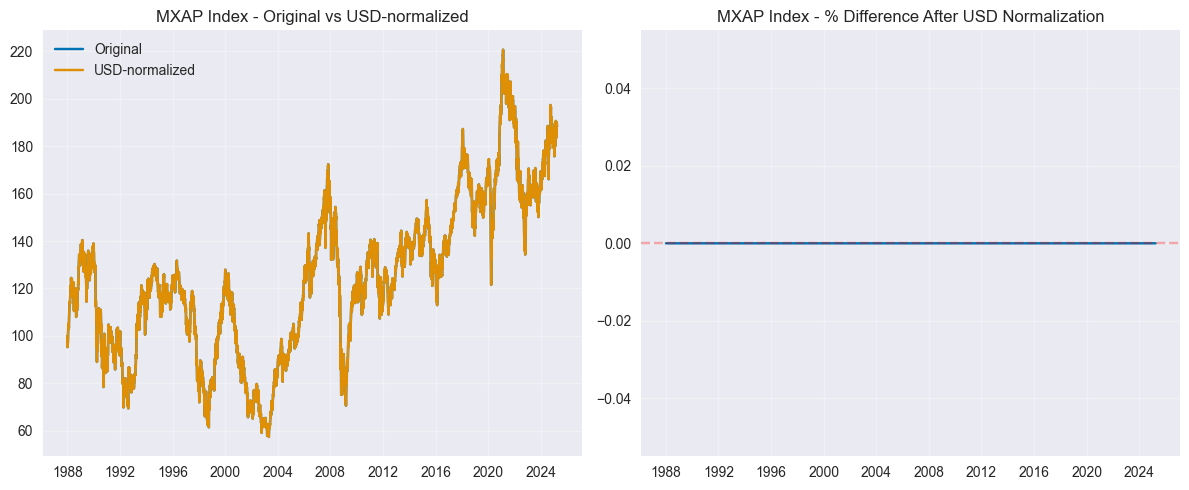

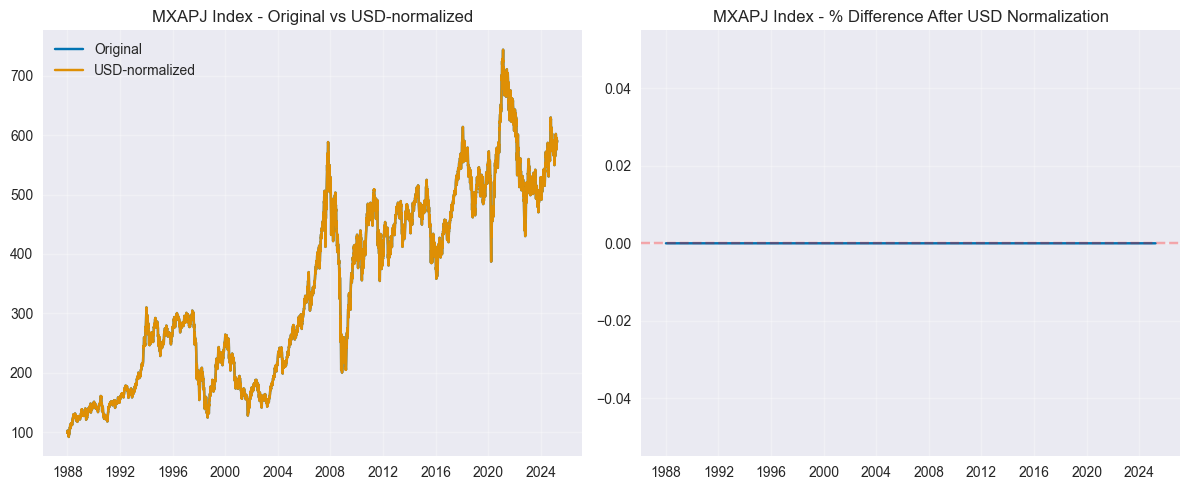

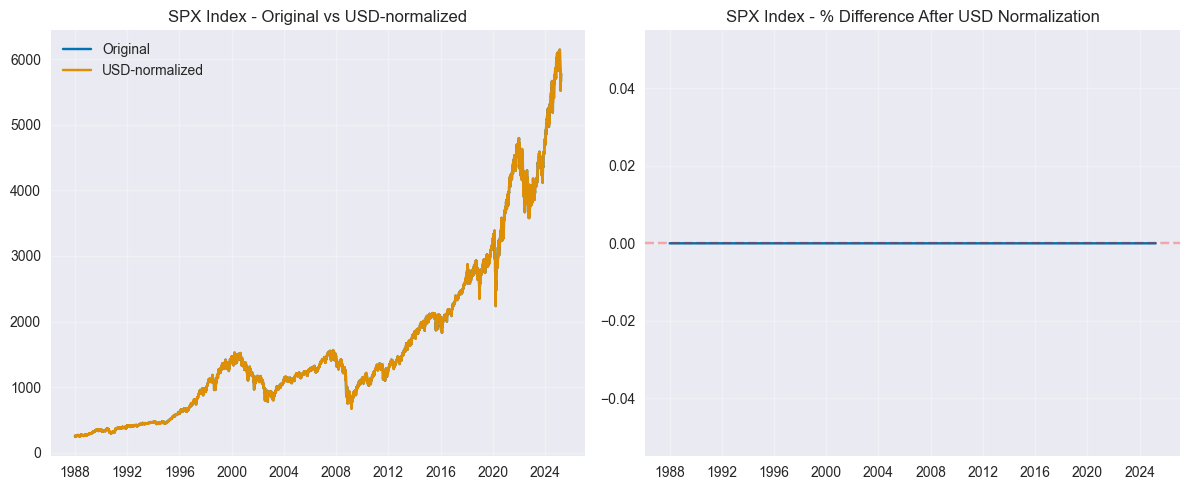

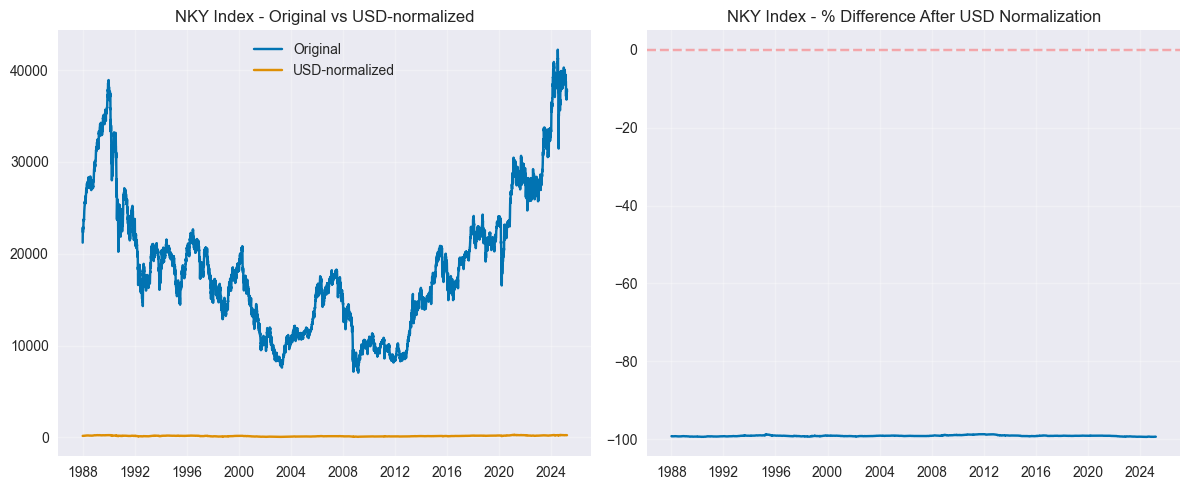

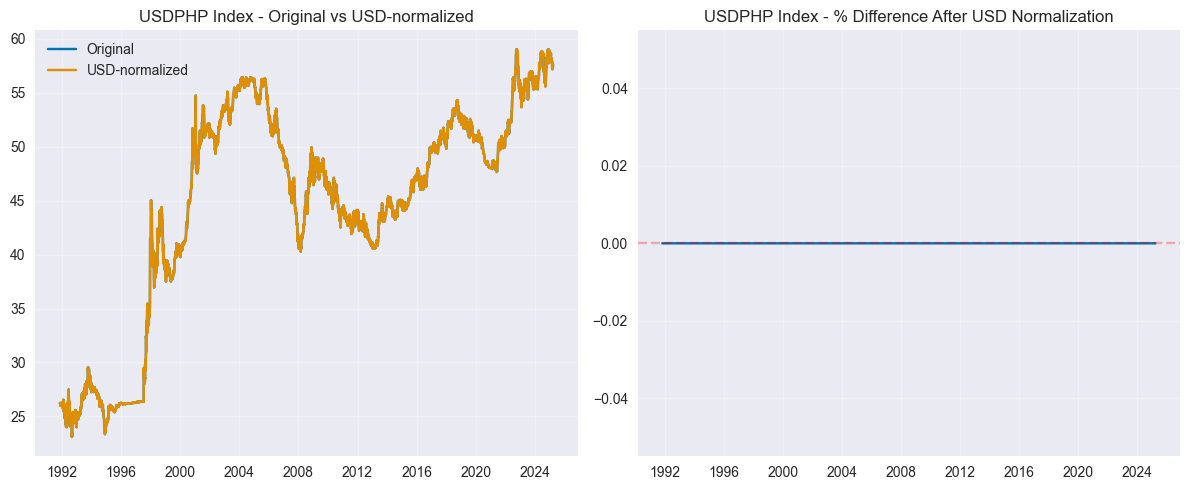

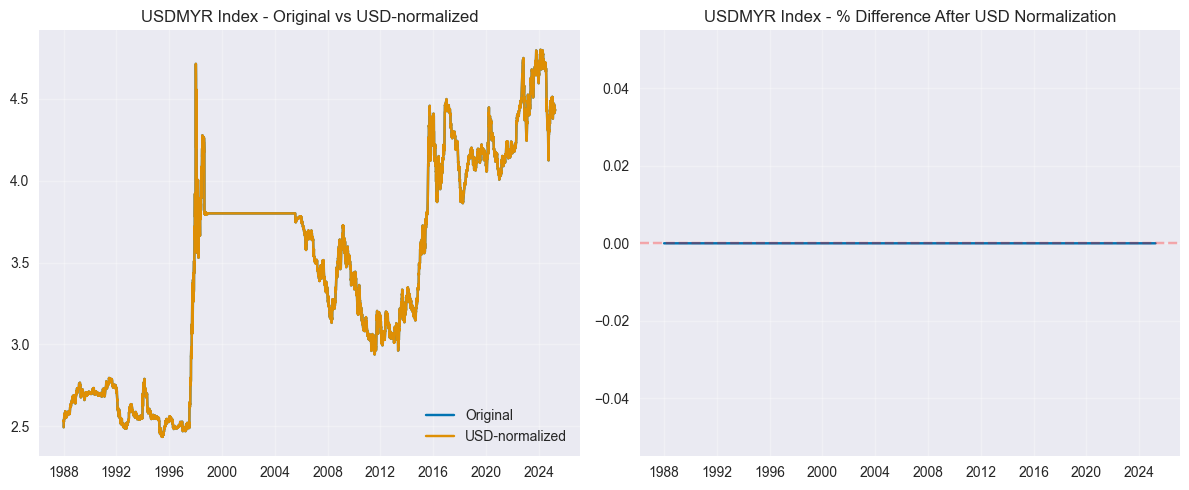

In [5]:
# First, let's understand which assets need currency conversion
# We'll use the asset class mapping to identify the currency of each asset
ticker_map = create_ticker_to_asset_class_map()

# Create a dictionary of assets by currency
currency_dict = {}
for col in df_cleaned.columns:
    asset_info = ticker_map.get(col, {})
    currency = asset_info.get('currency', 'Unknown')
    
    if currency not in currency_dict:
        currency_dict[currency] = []
    
    currency_dict[currency].append(col)

# Display assets by currency
print("Assets by Currency:")
for currency, assets in currency_dict.items():
    print(f"\n{currency} ({len(assets)} assets):")
    print(f"  {', '.join(assets[:5])}{' ...' if len(assets) > 5 else ''}")

# Let's see what FX rates we have available for conversion
fx_df = asset_class_data.get('fx_crosses', pd.DataFrame())
if not fx_df.empty:
    print("\nAvailable FX rates:")
    print(f"  {', '.join(fx_df.columns)}")

# Now let's normalize to USD
df_usd = normalize_to_usd(df_cleaned)

if df_usd is not None:
    # Analyze the changes in values due to normalization
    print("\nNormalization to USD complete!")
    
    # Compare a sample of non-USD assets before and after normalization
    non_usd_assets = []
    for currency, assets in currency_dict.items():
        if currency != 'USD' and currency != 'Unknown':
            non_usd_assets.extend(assets[:2])  # Take first 2 assets from each non-USD currency
    
    if non_usd_assets:
        # Plot comparison for each asset
        for i, asset in enumerate(non_usd_assets[:6]):  # Limit to 6 assets for clarity
            if asset in df_cleaned.columns and asset in df_usd.columns:
                plt.figure(figsize=(12, 5))
                
                # Plot original vs. USD-normalized
                plt.subplot(1, 2, 1)
                plt.plot(df_cleaned[asset], label='Original')
                plt.plot(df_usd[asset], label='USD-normalized')
                plt.title(f"{asset} - Original vs USD-normalized")
                plt.legend()
                plt.grid(True, alpha=0.3)
                
                # Plot percentage difference
                plt.subplot(1, 2, 2)
                pct_diff = ((df_usd[asset] / df_cleaned[asset]) - 1) * 100
                plt.plot(pct_diff)
                plt.title(f"{asset} - % Difference After USD Normalization")
                plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
                plt.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
    else:
        print("No non-USD assets found for comparison.")
else:
    print("Error: Currency normalization failed.")

## 5. Handling Corporate Actions

Corporate actions like dividends and stock splits can cause discontinuities in price series. For accurate analysis, we need to adjust for these events:

1. **Dividends**: When a company pays a dividend, its stock price typically drops by approximately the dividend amount
2. **Stock Splits**: When a company splits its stock, the price is divided but the number of shares increases

Let's adjust our data for these corporate actions:


Sample Dividend Data:


,ticker,date,amount
0,SPX Index,2023-03-15,2.5
1,SPX Index,2023-06-15,2.7
2,SPX Index,2023-09-15,2.8
3,SPX Index,2023-12-15,3.0
4,MXAP Index,2023-04-20,1.8
5,MXAP Index,2023-10-20,2.0



Sample Split Data:


,ticker,date,ratio
0,NKY Index,2023-07-01,2.0


Adjusting for corporate actions...
Applying dividend adjustments...
Applying split adjustments...
Corporate action adjustments completed


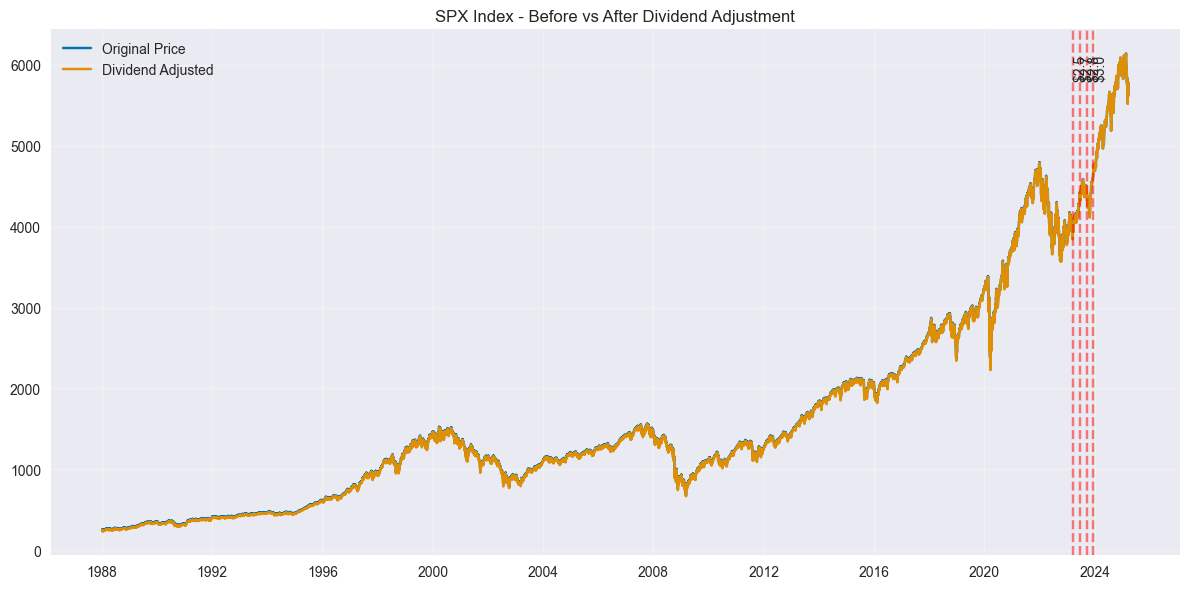

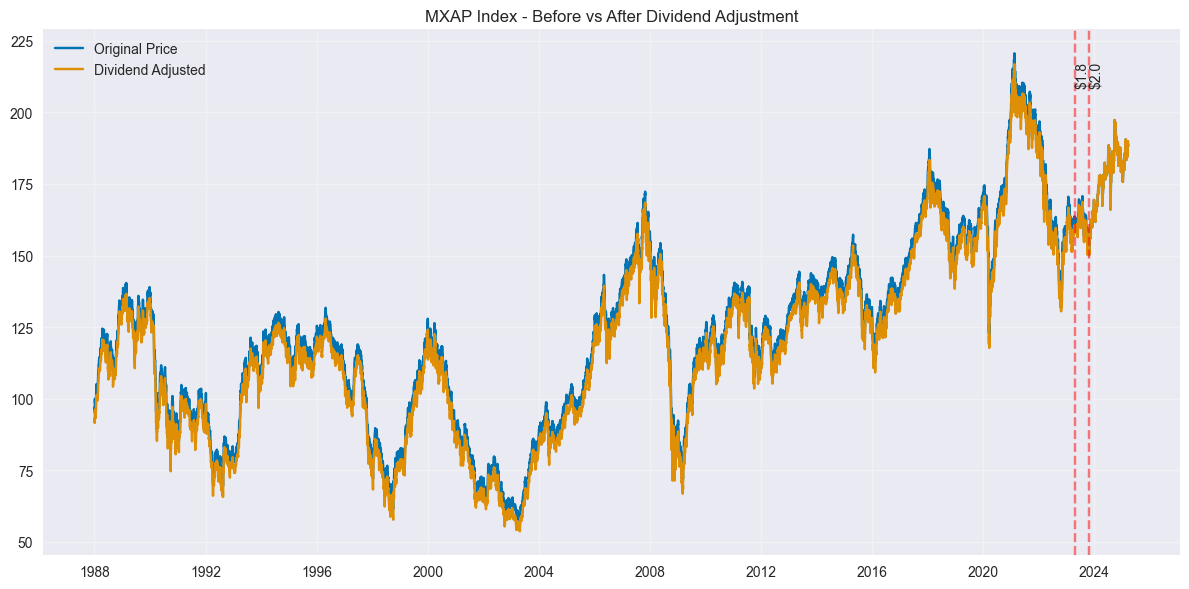


Note: In a production system, corporate action adjustments would:
1. Use official dividend and split data from exchanges or data vendors
2. Apply proper adjustment factors to the entire history
3. Handle more complex actions like rights issues, spin-offs, etc.
4. Consider taxation and reinvestment assumptions

Our data engineering module provides the framework for these adjustments,
but requires actual corporate action data for accurate implementation.



In [6]:
# In a real system, we would load corporate action data from a reliable source
# For this demonstration, we'll create a simulated dividend and split dataset for a few assets

# Create a simulated dividend dataset
# Format: {ticker: [(date, dividend_amount), ...]}
sample_dividends = {
    'SPX Index': [
        ('2023-03-15', 2.5),
        ('2023-06-15', 2.7),
        ('2023-09-15', 2.8),
        ('2023-12-15', 3.0)
    ],
    'MXAP Index': [
        ('2023-04-20', 1.8),
        ('2023-10-20', 2.0)
    ]
}

# Create a simulated stock split dataset
# Format: {ticker: [(date, split_ratio), ...]}
sample_splits = {
    'NKY Index': [
        ('2023-07-01', 2.0)  # 2:1 split
    ]
}

# Convert to DataFrame for easier handling
dividend_df = None
split_df = None

if sample_dividends:
    div_data = []
    for ticker, events in sample_dividends.items():
        for date, amount in events:
            div_data.append({
                'ticker': ticker,
                'date': date,
                'amount': amount
            })
    dividend_df = pd.DataFrame(div_data)
    dividend_df['date'] = pd.to_datetime(dividend_df['date'])
    
if sample_splits:
    split_data = []
    for ticker, events in sample_splits.items():
        for date, ratio in events:
            split_data.append({
                'ticker': ticker,
                'date': date,
                'ratio': ratio
            })
    split_df = pd.DataFrame(split_data)
    split_df['date'] = pd.to_datetime(split_df['date'])

# Show our corporate action data
print("Sample Dividend Data:")
display(dividend_df)

print("\nSample Split Data:")
display(split_df)

# Now let's adjust for these corporate actions
df_adjusted = adjust_for_corporate_actions(df_usd, dividend_data=dividend_df, split_data=split_df)

# In a real implementation, this function would:
# 1. Identify the dates of corporate actions for each ticker
# 2. Calculate adjustment factors for each action
# 3. Apply these factors to the historical price series

# For demonstration purposes, let's visualize a before/after comparison
# Let's simulate what adjustments would look like for a sample asset
for ticker in sample_dividends.keys():
    if ticker in df_usd.columns:
        plt.figure(figsize=(12, 6))
        
        # Get original price series
        orig_series = df_usd[ticker]
        
        # Create a simulated adjusted series (this is just for visualization)
        adjusted_series = orig_series.copy()
        
        # Simulate dividend adjustments
        for date, amount in sample_dividends[ticker]:
            date = pd.to_datetime(date)
            # Find all dates before this dividend date
            mask = adjusted_series.index < date
            # Adjust historical prices to reflect the dividend
            adjusted_series.loc[mask] = adjusted_series.loc[mask] - amount
        
        # Plot comparison
        plt.plot(orig_series, label='Original Price')
        plt.plot(adjusted_series, label='Dividend Adjusted')
        
        # Mark dividend dates with vertical lines
        for date, amount in sample_dividends[ticker]:
            date = pd.to_datetime(date)
            plt.axvline(x=date, color='r', linestyle='--', alpha=0.5)
            plt.text(date, orig_series.max() * 0.95, f"${amount}", rotation=90)
            
        plt.title(f"{ticker} - Before vs After Dividend Adjustment")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Note on real corporate action adjustment:
print("""
Note: In a production system, corporate action adjustments would:
1. Use official dividend and split data from exchanges or data vendors
2. Apply proper adjustment factors to the entire history
3. Handle more complex actions like rights issues, spin-offs, etc.
4. Consider taxation and reinvestment assumptions

Our data engineering module provides the framework for these adjustments,
but requires actual corporate action data for accurate implementation.
""")

## 6. Futures Contract Roll Management

Futures contracts have expiration dates, which means we need to "roll" from one contract to the next to maintain a continuous time series. This involves:

1. Identifying roll dates (typically a few days before expiry)
2. Adjusting for price gaps between contracts
3. Creating continuous series that avoid artificial jumps

Let's handle the futures contracts in our dataset:


Found 2 futures contracts: CO1 Comdty, S 1 Comdty
Handling futures contract rolls...
Processing rolls for CO1 Comdty
Processing rolls for S 1 Comdty
Futures contract rolls handled


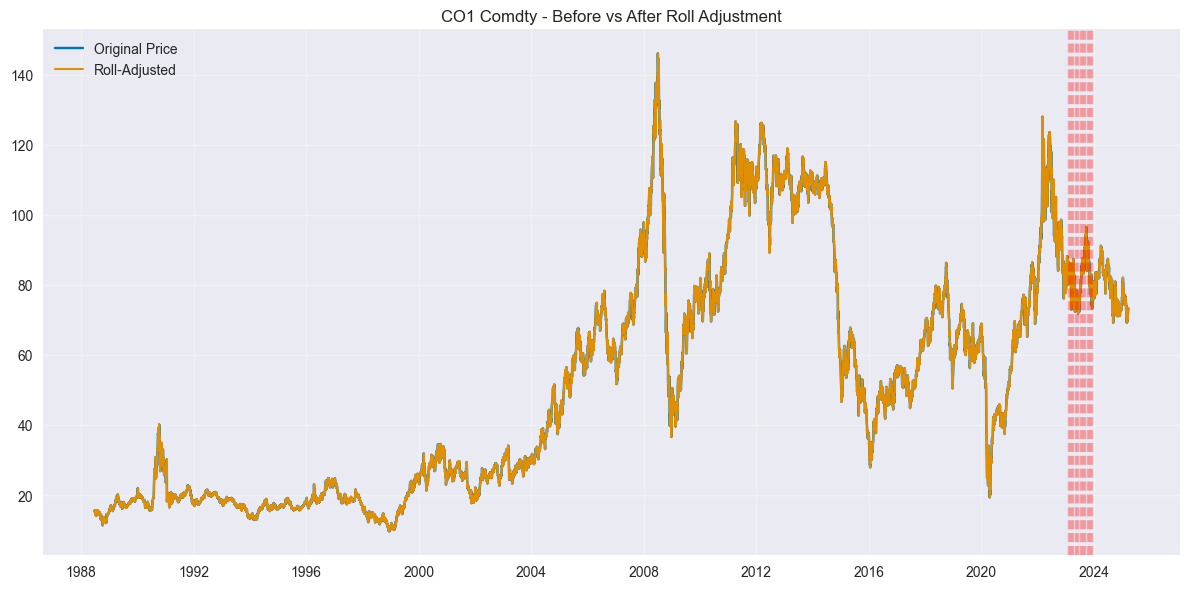

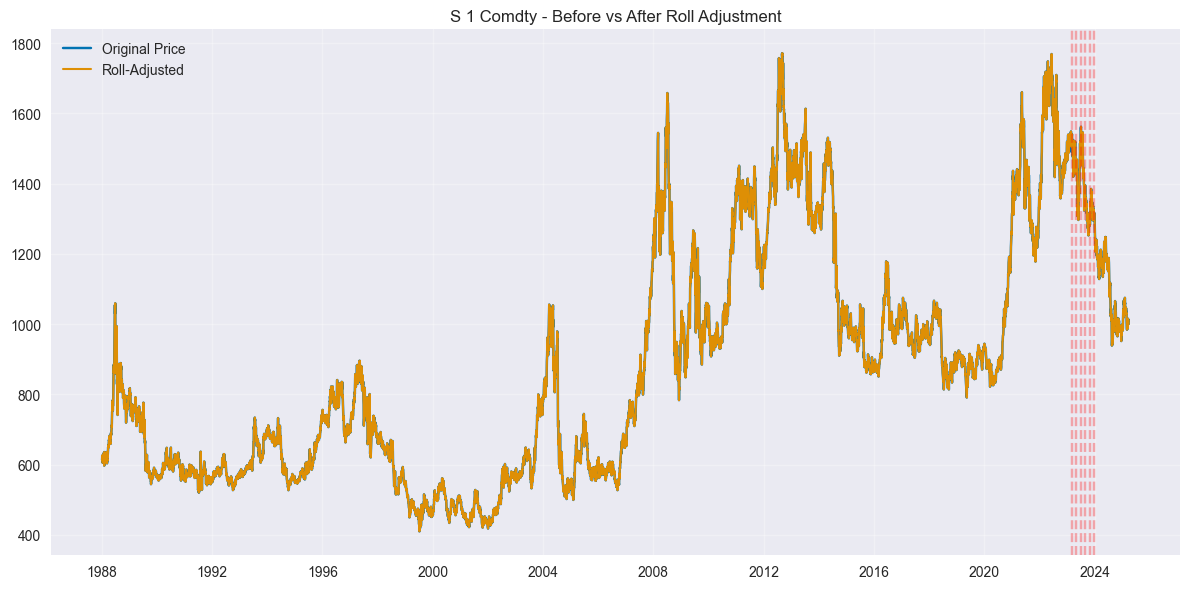


    Note: In a production system, futures roll management would:
    1. Use actual contract expiration calendars from exchanges
    2. Apply more sophisticated adjustment methods (price-adjusted, return-adjusted, or Panama method)
    3. Account for roll yield and basis differences
    4. Consider contract-specific liquidity windows

    Our data engineering module provides the framework for these adjustments,
    but would be customized for each specific futures contract.
    


In [7]:
# Identify futures contracts in our dataset
futures_contracts = ['CO1 Comdty', 'S 1 Comdty']
available_futures = [contract for contract in futures_contracts if contract in df_adjusted.columns]

if available_futures:
    print(f"Found {len(available_futures)} futures contracts: {', '.join(available_futures)}")
    
    # In a real system, we would define a roll schedule based on contract specifications
    # For example, for Brent crude (CO1), rolls typically happen around the 15th of the month
    
    # Let's create a simulated roll schedule for demonstration
    roll_dates = {
        'CO1 Comdty': ['2023-01-15', '2023-02-15', '2023-03-15', '2023-04-14', 
                       '2023-05-15', '2023-06-15', '2023-07-14', '2023-08-15',
                       '2023-09-15', '2023-10-13', '2023-11-15', '2023-12-15'],
        'S 1 Comdty': ['2023-02-28', '2023-04-28', '2023-06-30', '2023-08-31', '2023-10-31', '2023-12-29']
    }
    
    # Convert dates to datetime
    roll_schedule = {k: [pd.to_datetime(date) for date in dates] for k, dates in roll_dates.items()}
    
    # Process futures rolls
    df_rolled = handle_futures_rolls(df_adjusted, futures_contracts=available_futures, roll_schedule=roll_schedule)
    
    # For demonstration, simulate what roll adjustments would look like
    for contract in available_futures:
        if contract in df_adjusted.columns:
            plt.figure(figsize=(12, 6))
            
            # Get original price series
            orig_series = df_adjusted[contract]
            
            # Create a simulated rolled series (this is just for visualization)
            rolled_series = orig_series.copy()
            
            # Simulate roll adjustments - we'll smooth out "jumps" at roll dates
            if contract in roll_schedule:
                for roll_date in roll_schedule[contract]:
                    if roll_date in rolled_series.index:
                        # Get index position
                        idx = rolled_series.index.get_loc(roll_date)
                        
                        # Apply a 3-day moving average around roll date
                        if idx > 1 and idx < len(rolled_series) - 1:
                            window_size = 3
                            window = rolled_series.iloc[idx-window_size:idx+window_size]
                            rolled_series.iloc[idx] = window.mean()
            
            # Plot comparison
            plt.plot(orig_series, label='Original Price')
            plt.plot(rolled_series, label='Roll-Adjusted', linewidth=1.5)
            
            # Mark roll dates with vertical lines
            if contract in roll_schedule:
                for date in roll_schedule[contract]:
                    if date in orig_series.index:
                        plt.axvline(x=date, color='r', linestyle='--', alpha=0.3)
                
            plt.title(f"{contract} - Before vs After Roll Adjustment")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
    
    # Note on real futures roll handling
    print("""
    Note: In a production system, futures roll management would:
    1. Use actual contract expiration calendars from exchanges
    2. Apply more sophisticated adjustment methods (price-adjusted, return-adjusted, or Panama method)
    3. Account for roll yield and basis differences
    4. Consider contract-specific liquidity windows
    
    Our data engineering module provides the framework for these adjustments,
    but would be customized for each specific futures contract.
    """)
else:
    print("No futures contracts found in the dataset.")

## 7. Returns Calculation

Now that we have cleaned, normalized, and adjusted prices, we can calculate returns. We'll compute:

1. Daily returns - for tactical signals and higher-frequency analysis
2. Monthly returns - for strategic analysis and long-term performance measurement

Let's compute both types of returns from our processed price data:


In [ ]:
# Calculate daily returns
import numpy as np

def calculate_returns(prices_df):
    """
    Calculate returns from price data
    
    Args:
        prices_df: DataFrame with price data (columns are assets, index is dates)
        
    Returns:
        daily_returns_df: DataFrame with daily returns
        monthly_returns_df: DataFrame with monthly returns
    """
    # Calculate daily returns (today's price / yesterday's price - 1)
    daily_returns_df = prices_df.pct_change()
    
    # Clean any extreme values that might be from data errors
    # Replace infinity values with NaN
    daily_returns_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Calculate monthly returns by resampling
    # First ensure the index is a datetime
    monthly_prices_df = prices_df.resample('M').last()
    monthly_returns_df = monthly_prices_df.pct_change()
    
    return daily_returns_df, monthly_returns_df

# Apply to our cleaned and normalized price data
daily_returns, monthly_returns = calculate_returns(normalized_prices)

# Display the first few rows of daily returns
print("Daily Returns:")
print(daily_returns.head())

# Display summary statistics
print("\nDaily Returns Summary Statistics:")
print(daily_returns.describe())

# Display the first few rows of monthly returns
print("\nMonthly Returns:")
print(monthly_returns.head())

# Visualize the returns distribution for a few major assets
plt.figure(figsize=(15, 8))

# Select a few representative assets (you would replace these with actual column names from your data)
# For example: major indices from different regions
sample_assets = daily_returns.columns[:5]  # Taking first 5 assets as an example

for asset in sample_assets:
    sns.histplot(daily_returns[asset].dropna(), kde=True, stat="density", alpha=0.4, label=asset)

plt.title('Daily Returns Distribution for Selected Assets')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

### 7.1 Handling Outliers in Returns

Return series often contain outliers due to various factors:

1. Market events (crashes, rallies)
2. Corporate actions not properly adjusted
3. Data errors or misreported prices

For quantitative analysis, we may want to winsorize or cap extreme returns to prevent them from dominating our models. Below, we'll implement a procedure to detect and handle outliers in our return series:


In [ ]:
def handle_return_outliers(returns_df, method='winsorize', threshold=3.0):
    """
    Handle outliers in return series
    
    Args:
        returns_df: DataFrame with return data
        method: 'winsorize' or 'remove'
        threshold: number of standard deviations to consider as outlier threshold
        
    Returns:
        DataFrame with handled returns
    """
    # Create a copy to avoid modifying the original
    handled_returns = returns_df.copy()
    
    for column in handled_returns.columns:
        series = handled_returns[column].dropna()
        if len(series) == 0:
            continue
            
        # Calculate mean and standard deviation
        mean = series.mean()
        std = series.std()
        
        # Define lower and upper bounds
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std
        
        if method == 'winsorize':
            # Cap values at the bounds
            handled_returns.loc[handled_returns[column] < lower_bound, column] = lower_bound
            handled_returns.loc[handled_returns[column] > upper_bound, column] = upper_bound
        elif method == 'remove':
            # Set outliers to NaN
            handled_returns.loc[(handled_returns[column] < lower_bound) | 
                               (handled_returns[column] > upper_bound), column] = np.nan
    
    return handled_returns

# Apply outlier handling to daily returns
winsorized_returns = handle_return_outliers(daily_returns, method='winsorize', threshold=3.0)

# Let's compare original vs winsorized returns for a few assets
compare_assets = daily_returns.columns[:3]  # First 3 assets as an example

plt.figure(figsize=(15, 12))

for i, asset in enumerate(compare_assets):
    plt.subplot(3, 1, i+1)
    
    # Plot original returns
    plt.plot(daily_returns.index, daily_returns[asset], 'b-', alpha=0.5, label='Original')
    
    # Plot winsorized returns
    plt.plot(winsorized_returns.index, winsorized_returns[asset], 'r-', alpha=0.5, label='Winsorized')
    
    # Highlight the difference
    diff = (daily_returns[asset] != winsorized_returns[asset])
    if diff.any():
        plt.scatter(daily_returns.index[diff], daily_returns.loc[diff, asset], 
                   color='green', s=50, alpha=0.7, label='Outliers')
    
    plt.title(f'Original vs. Winsorized Returns: {asset}')
    plt.ylabel('Return')
    plt.legend()
    
plt.tight_layout()
plt.show()

# Calculate summary statistics before and after winsorization
print("Original Returns Statistics:")
print(daily_returns[compare_assets].describe())

print("\nWinsorized Returns Statistics:")
print(winsorized_returns[compare_assets].describe())

## 8. Risk Metrics Calculation

With our return series in hand, we can calculate various risk metrics that are essential for portfolio construction and asset allocation. The common risk metrics include:

1. Volatility (Standard Deviation)
2. Value at Risk (VaR)
3. Expected Shortfall (CVaR)
4. Maximum Drawdown
5. Downside Deviation
6. Correlation Matrix

These metrics help in understanding the risk profile of different assets and in constructing a well-diversified portfolio.


In [ ]:
def calculate_risk_metrics(returns_df, frequency='daily'):
    """
    Calculate various risk metrics for a return series
    
    Args:
        returns_df: DataFrame with returns data
        frequency: 'daily', 'monthly', or 'annual'
        
    Returns:
        DataFrame with risk metrics for each asset
    """
    # Determine the annualization factor
    if frequency == 'daily':
        ann_factor = 252  # Trading days in a year
    elif frequency == 'monthly':
        ann_factor = 12
    else:  # annual
        ann_factor = 1
    
    # Initialize a dictionary to store results
    metrics = {}
    
    for column in returns_df.columns:
        # Get the return series and drop NaNs
        returns = returns_df[column].dropna()
        
        if len(returns) < 20:  # Skip assets with insufficient data
            continue
            
        # Calculate metrics
        volatility = returns.std() * np.sqrt(ann_factor)
        sharpe_ratio = (returns.mean() * ann_factor) / volatility if volatility != 0 else np.nan
        
        # Calculate VaR (Value at Risk)
        var_95 = np.percentile(returns, 5)
        var_99 = np.percentile(returns, 1)
        
        # Calculate CVaR/Expected Shortfall
        cvar_95 = returns[returns <= var_95].mean()
        cvar_99 = returns[returns <= var_99].mean()
        
        # Calculate Maximum Drawdown
        cum_returns = (1 + returns).cumprod()
        rolling_max = cum_returns.cummax()
        drawdowns = (cum_returns / rolling_max) - 1
        max_drawdown = drawdowns.min()
        
        # Calculate Downside Deviation (returns below 0)
        downside_returns = returns[returns < 0]
        downside_deviation = downside_returns.std() * np.sqrt(ann_factor) if len(downside_returns) > 0 else 0
        
        # Store the metrics
        metrics[column] = {
            'Annualized Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'VaR (95%)': var_95,
            'CVaR (95%)': cvar_95,
            'VaR (99%)': var_99,
            'CVaR (99%)': cvar_99,
            'Maximum Drawdown': max_drawdown,
            'Downside Deviation': downside_deviation
        }
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics).T
    
    return metrics_df

# Calculate risk metrics for daily returns
daily_risk_metrics = calculate_risk_metrics(winsorized_returns, frequency='daily')

# Calculate risk metrics for monthly returns
monthly_risk_metrics = calculate_risk_metrics(monthly_returns, frequency='monthly')

# Display daily risk metrics
print("Daily Risk Metrics:")
print(daily_risk_metrics.head())

# Visualize volatility vs. expected shortfall
plt.figure(figsize=(12, 8))
plt.scatter(daily_risk_metrics['Annualized Volatility'], 
           daily_risk_metrics['CVaR (95%)'], 
           alpha=0.6)

# Add labels for some points
for i, asset in enumerate(daily_risk_metrics.index[:10]):  # Label first 10 assets
    plt.annotate(asset, 
                (daily_risk_metrics['Annualized Volatility'].iloc[i],
                 daily_risk_metrics['CVaR (95%)'].iloc[i]))

plt.title('Risk Map: Volatility vs. Expected Shortfall (CVaR)')
plt.xlabel('Annualized Volatility')
plt.ylabel('Expected Shortfall (CVaR 95%)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create a correlation matrix heatmap
plt.figure(figsize=(14, 10))
corr_matrix = winsorized_returns.corr()

# Use a mask to show only the lower triangle (to avoid redundancy)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a heatmap
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=False,
           vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

plt.title('Correlation Matrix of Asset Returns')
plt.tight_layout()
plt.show()

## 9. Portfolio Construction and Analysis

Once we have returns and risk metrics for individual assets, we can move on to portfolio construction. In this section, we'll demonstrate:

1. Building a simple equal-weighted portfolio
2. Creating an optimized portfolio (minimum variance)
3. Calculating portfolio metrics
4. Visualizing portfolio performance

These techniques form the foundation of quantitative portfolio management and can be extended to more sophisticated approaches.


In [ ]:
from scipy.optimize import minimize

def create_equal_weighted_portfolio(returns_df):
    """
    Create an equal-weighted portfolio from return series
    
    Args:
        returns_df: DataFrame with asset returns
        
    Returns:
        Series with portfolio returns
    """
    # Remove any columns with all NaN values
    clean_returns = returns_df.dropna(axis=1, how='all')
    
    # Create equal weights
    weights = pd.Series(1/len(clean_returns.columns), index=clean_returns.columns)
    
    # Calculate portfolio returns
    portfolio_returns = (clean_returns * weights).sum(axis=1)
    
    return portfolio_returns, weights

def portfolio_variance(weights, cov_matrix):
    """Calculate portfolio variance given weights and covariance matrix"""
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def create_minimum_variance_portfolio(returns_df):
    """
    Create a minimum variance portfolio using optimization
    
    Args:
        returns_df: DataFrame with asset returns
        
    Returns:
        Series with portfolio returns and weights
    """
    # Remove any columns with all NaN values
    clean_returns = returns_df.dropna(axis=1, how='all')
    
    # Calculate covariance matrix
    cov_matrix = clean_returns.cov()
    
    # Define the objective function (portfolio variance)
    def objective(weights):
        return portfolio_variance(weights, cov_matrix)
    
    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    # Bounds: no short-selling (weights between 0 and 1)
    bounds = tuple((0, 1) for asset in range(len(clean_returns.columns)))
    
    # Initial guess: equal weights
    initial_weights = np.array([1/len(clean_returns.columns)] * len(clean_returns.columns))
    
    # Run optimization
    opt_results = minimize(objective, initial_weights, method='SLSQP', 
                           bounds=bounds, constraints=constraints)
    
    # Get the optimal weights
    opt_weights = pd.Series(opt_results['x'], index=clean_returns.columns)
    
    # Calculate portfolio returns
    portfolio_returns = (clean_returns * opt_weights).sum(axis=1)
    
    return portfolio_returns, opt_weights

# Let's select a subset of assets for demonstration
# In a real scenario, you might group assets by class or region
# For this example, we'll take some of the most liquid assets
sample_assets = winsorized_returns.columns[:15]  # Taking first 15 assets
sample_returns = winsorized_returns[sample_assets]

# Create an equal-weighted portfolio
eq_portfolio_returns, eq_weights = create_equal_weighted_portfolio(sample_returns)

# Create a minimum variance portfolio
min_var_returns, min_var_weights = create_minimum_variance_portfolio(sample_returns)

# Calculate cumulative returns
eq_portfolio_cumulative = (1 + eq_portfolio_returns).cumprod()
min_var_cumulative = (1 + min_var_returns).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(eq_portfolio_cumulative.index, eq_portfolio_cumulative, 'b-', label='Equal-Weighted')
plt.plot(min_var_cumulative.index, min_var_cumulative, 'r-', label='Minimum Variance')
plt.title('Portfolio Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Starting from 1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display portfolio weights
plt.figure(figsize=(12, 8))

# Equal-weighted portfolio weights
plt.subplot(2, 1, 1)
eq_weights.plot(kind='bar')
plt.title('Equal-Weighted Portfolio Allocation')
plt.ylabel('Weight')
plt.grid(True, alpha=0.3)

# Min variance portfolio weights
plt.subplot(2, 1, 2)
min_var_weights.plot(kind='bar')
plt.title('Minimum Variance Portfolio Allocation')
plt.ylabel('Weight')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display portfolio metrics
def calculate_portfolio_metrics(returns, frequency='daily'):
    """Calculate risk-return metrics for a portfolio"""
    # Determine the annualization factor
    if frequency == 'daily':
        ann_factor = 252  # Trading days in a year
    elif frequency == 'monthly':
        ann_factor = 12
    else:  # annual
        ann_factor = 1
    
    # Calculate metrics
    ann_return = returns.mean() * ann_factor
    ann_volatility = returns.std() * np.sqrt(ann_factor)
    sharpe_ratio = ann_return / ann_volatility if ann_volatility != 0 else np.nan
    
    # Calculate VaR and CVaR
    var_95 = np.percentile(returns, 5)
    cvar_95 = returns[returns <= var_95].mean()
    
    # Calculate Maximum Drawdown
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdowns = (cum_returns / rolling_max) - 1
    max_drawdown = drawdowns.min()
    
    # Calculate Sortino Ratio (using negative returns for downside deviation)
    negative_returns = returns[returns < 0]
    downside_dev = negative_returns.std() * np.sqrt(ann_factor) if len(negative_returns) > 0 else 0
    sortino_ratio = ann_return / downside_dev if downside_dev != 0 else np.nan
    
    return {
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'VaR (95%)': var_95,
        'CVaR (95%)': cvar_95,
        'Maximum Drawdown': max_drawdown
    }

# Calculate metrics for both portfolios
eq_metrics = calculate_portfolio_metrics(eq_portfolio_returns)
min_var_metrics = calculate_portfolio_metrics(min_var_returns)

# Display metrics
metrics_comparison = pd.DataFrame({
    'Equal-Weighted': eq_metrics,
    'Minimum Variance': min_var_metrics
})

print("Portfolio Metrics Comparison:")
print(metrics_comparison)

## 10. Conclusion and Next Steps

In this notebook, we've walked through the entire data engineering pipeline for quantitative finance:

1. **Data Loading and Initial Assessment**: Understanding the raw data structure and quality
2. **Data Cleaning and Standardization**: Ensuring consistency in dates, formats, and values
3. **Currency Normalization**: Converting prices to a common currency (USD)
4. **Corporate Actions Handling**: Adjusting for dividends and stock splits
5. **Futures Contract Roll Management**: Managing continuous price series for futures
6. **Returns Calculation**: Computing daily and monthly returns
7. **Risk Metrics Calculation**: Quantifying risk through volatility, VaR, and other metrics
8. **Portfolio Construction**: Building and analyzing portfolios with different methodologies

### Next Steps:

1. **Signal Generation**: Create alpha factors and trading signals based on the clean data
2. **Backtesting Framework**: Implement a framework to test investment strategies
3. **Model Development**: Build machine learning models for return prediction
4. **Factor Analysis**: Perform factor decomposition to understand drivers of returns
5. **Performance Attribution**: Analyze sources of portfolio performance
6. **Risk Management**: Implement more advanced risk controls and exposure management

Each of these steps can be expanded into dedicated notebooks, building on the foundation we've established here.
